# «Прогнозирование оттока клиентов»

## ***Описание проекта***

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать
отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут
предложены промокоды и специальные условия. Команда оператора
собрала персональные данные о некоторых клиентах, информацию об их
тарифах и договорах.


## ***Описание данных***

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

## ***Обозначения признаков***

- customer_id - уникальный id пользователя,
- begin_date – дата начала пользования услугами,
- end_date – дата окончания пользования услугами,
- type – тип оплаты: ежемесячный, годовой и тд,
- paperless_billing – безналичный расчет,
- payment_method – способ оплаты,
- monthly_charges – ежемесячные траты на услуги,
- total_charges – всего потрачено денег на услуги,
- gender - пол пользователя,
- senior_citizen – наличие пенсионного статуса по возрасту,
- partner – наличие супруга(и),
- dependents – наличие иждивенцев,
- internet_service - тип интернет подключения или его отсутствие,
- online_security - наличие услуги онлайн безопасность,
- online_backup - наличие услуги онлайн резервное копирование,
- device_protection - наличие услуги защита устройства,
- tech_support - наличие услуги техническая поддержка,
- streaming_tv - наличие услуги потоковое телевещание,
- streaming_movies - наличие услуги потоковое видео,
- multiple_lines – наличие возможности ведения параллельных линий во время звонка.

## ***План исследования***

- Загрузка данных и объединение в одну таблицу по id.
- Изучение общей информации.
- Подготовка данных к анализу:
    - Приведем названия столбцов к нижнему регистру.
    - Преобразуем данные в нужные типы.
    - Обработаем пропуски при необходимости.
    - Проверим на наличие дубликатов.
- Исследовательский анализ данных.
- Подготовка данных к обучению моделей:
    - кодирование категориальных данных.
    - разделение данных на train и test.
- Обучение моделей:
    - подбор гиперпараметров при кросс валидации.
    - выбор лучшей модели.
- Проверка лучшей модели на тестовой выборке.
- Вывод.

In [1]:
# импортируем необходимые библиотеки
!pip install phik
!pip install -U scikit-learn

import pandas as pd
import numpy as np

import phik

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from tqdm import tqdm

import warnings

# настройки
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# константы
RS = 80523

In [2]:
# загрузим данные
try:
    phone = pd.read_csv('phone_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    contract = pd.read_csv('contract_new.csv')
except:
    phone = pd.read_csv('/datasets/phone_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    contract = pd.read_csv('/datasets/contract_new.csv')

In [3]:
# объединим датасеты в общую таблицу
df = pd.merge(contract, personal, on='customerID', how='outer')
df = pd.merge(df, internet, on='customerID', how='outer')
df = pd.merge(df, phone, on='customerID', how='outer')

In [4]:
# приведем названия к snake_case для удобства и выедем info
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
new_names = {'ustomer_i_d': 'customer_id', 
             'ender': 'gender', 
             'streaming_t_v': 'streaming_tv'}
df = df.rename(columns=new_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [5]:
# изучим первые 5 строк полученного датасета
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [6]:
# проверим колличество пропусков
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [7]:
# проверим на наличие дубликатов
df.duplicated().sum()

0

In [8]:
df[df['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [9]:
df[(df['begin_date'] > '2019-12-01') & (df['type'] == 'One year')].head(30)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
222,6469-MRVET,2020-01-01,No,One year,Yes,Electronic check,20.20,20.2,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1168,5562-BETPV,2020-01-01,No,One year,No,Mailed check,19.65,19.65,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1286,8985-OOPOS,2020-01-01,No,One year,No,Credit card (automatic),74.10,74.84,Female,0,No,No,DSL,No,No,Yes,Yes,Yes,Yes,No
1654,2967-MXRAV,2020-01-01,No,One year,No,Mailed check,18.80,19.74,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2993,2239-CFOUJ,2020-01-01,No,One year,No,Mailed check,20.40,21.62,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4767,1064-FBXNK,2020-01-01,No,One year,No,Credit card (automatic),19.85,21.44,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6149,3069-SSVSN,2020-01-01,No,One year,No,Mailed check,25.85,26.37,Female,0,No,No,DSL,No,No,No,No,No,No,NaN


При попытке сменить тип данных в признаке total_charges были обнаружены строковые значения - ' ', эти пользователи были зарегестрированны в день выгрузки данных и информацию о первом платеже еще не внесли. Заменим данные значения на значения из колонки monthly_charges, так как эти пользователи успели оплатить только первый месяц. Также изменим тип данных на float.

In [10]:
# создадим список индексов строк со значением ' ' в колонке total_charges
# пригодится нам для проверки изменений
index_list = list(df[df['total_charges'] == ' '].index)
index_list

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [11]:
# заполним пропуски в колонке 'total_charges' в зависимости от типа оплаты и ежемесячного платежа
def fill_total_charges(row):
    total_charges = row['total_charges']
    monthly_charges = row['monthly_charges']
    if total_charges == ' ':
        return monthly_charges
    return total_charges


df['total_charges'] = df.progress_apply(fill_total_charges, axis=1)

100%|██████████| 7043/7043 [00:00<00:00, 91713.86it/s]


In [12]:
# изменим тип данных колонки total_charges на float
df['total_charges'] = df['total_charges'].astype(float)

In [13]:
# проверим изменения по уже известным нам индексам
df.loc[index_list]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [14]:
# создадим признак таргет для дальнейшей работы
def fill_target(cell):
    if cell == 'No':
        return 0
    return 1


df['target'] = df['end_date'].progress_apply(fill_target)

100%|██████████| 7043/7043 [00:00<00:00, 784712.00it/s]


In [15]:
# сверим количество 'No' в end_date с количеством 0 в target
display(df['target'].value_counts())
display(df['end_date'].value_counts())

0    5942
1    1101
Name: target, dtype: int64

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-09-01       2
2014-10-01       1
2014-11-01       1
2014-06-01       1
Name: end_date, Length: 67, dtype: int64

In [16]:
# заменим 'No' в end_date на дату выгрузки данных для получения еще одного признака
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

In [17]:
# изменим тип данных begin_date и end_date на datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [18]:
# добавим новый признак длительность контракта - contract_duration
df['contract_duration'] = df['end_date'] - df['begin_date']

In [19]:
# посмотрим на результат
df['contract_duration']

0        31 days
1      1036 days
2       123 days
3      1371 days
4       153 days
          ...   
7038    730 days
7039   2191 days
7040    337 days
7041    215 days
7042   2010 days
Name: contract_duration, Length: 7043, dtype: timedelta64[ns]

Все оставшиеся пропуски у нас находятся в признаках наличия подключенной услуги. Будем считать что пропуски означают отсутствие данной услуги и заполним все строкой 'No'. 

In [20]:
# заполним все пропуски значением 'No' и проверим результат
df = df.fillna('No')
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
target               0
contract_duration    0
dtype: int64

In [21]:
# пройдемся циклом по всем признакам и методом value_count посмотрим распределение значений
for col in df.columns:
    print('='*20)
    print(col)
    print('='*20)
    print(df[col].value_counts().sort_index())

customer_id
0002-ORFBO    1
0003-MKNFE    1
0004-TLHLJ    1
0011-IGKFF    1
0013-EXCHZ    1
             ..
9987-LUTYD    1
9992-RRAMN    1
9992-UJOEL    1
9993-LHIEB    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
begin_date
2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
             ... 
2019-10-01    237
2019-11-01    237
2019-12-01    220
2020-01-01    233
2020-02-01     11
Name: begin_date, Length: 77, dtype: int64
end_date
2014-06-01       1
2014-09-01       2
2014-10-01       1
2014-11-01       1
2014-12-01       2
              ... 
2019-10-01      31
2019-11-01      30
2019-12-01      38
2020-01-01      39
2020-02-01    5942
Name: end_date, Length: 67, dtype: int64
type
Month-to-month    3875
One year          1473
Two year          1695
Name: type, dtype: int64
paperless_billing
No     2872
Yes    4171
Name: paperless_billing, dtype: int64
payment_method
Bank transfer (automatic)    1544
Credit card (automatic)    

In [22]:
# рассмотрим некоторые описательные статистики с помощью метода describe
df[['monthly_charges', 'total_charges', 'contract_duration']].describe()

,monthly_charges,total_charges,contract_duration
count,7043.000000,7043.000000,7043
mean,64.761692,2115.377573,898 days 13:20:14.993610672
std,30.090047,2112.678861,683 days 03:07:56.034286544
min,18.250000,19.050000,0 days 00:00:00
25%,35.500000,436.750000,276 days 00:00:00
50%,70.350000,1343.350000,761 days 00:00:00
75%,89.850000,3236.690000,1461 days 00:00:00
max,118.750000,9221.380000,2314 days 00:00:00


После детального рассмотрения данных нам известно:
- Первые клиенты компании зарегистрировались в октябре 2013г, последнии в день выгрузки данных - февраль 2020.
- Первый клиент отказавшийся от услуг - июнь 2014. Количество отказов росло с ростом появления новых клиентов.
- Большинство клиентов выбирает ежемесячную оплату за услуги и безналичный расчет.
- Метод оплаты равномерно распределен среди 4х способов с небольшим перевесом у 'Электронный чек'
- Ежемесячная оплата от 18.25 до 118.75, среднее в районе 65, медиана 70.35.
- Обшие траты на услуги за все время от 19.05 до 9221.38 среднее 2116.8, медиана 1344.5. Распределение смещено.
- Пользователей по половому признаку примерно поровну.
- Пенсионный статус примерно у 16% пользователей.
- Пользователей в браке и вне примерно поровну.
- Интернет сервис: оптоволокно немного предпочтительнее DSL. Услугой не пользуется около 21% клиентов компании.
- Всеми доп. услугами к интернет соединению пользуются примерно поровну.
- Длительность контракта от 0 дней до 2314 дней, среднее 898 дней, медиана 761 день. Средний показатель продолжительности контракта на момент выгрузки данных около 2.5 лет.


,monthly_charges,total_charges,target
target,0.226280,0.304287,1.000000
total_charges,0.711029,1.000000,0.304287
monthly_charges,1.000000,0.711029,0.226280


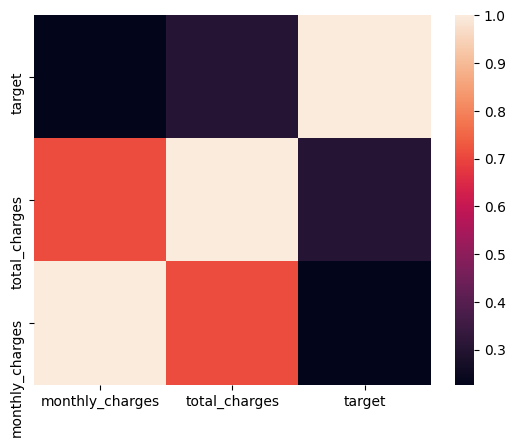

In [23]:
# проверим кореляцию 2х числовых признаков и их связь с таргетом
phik = df[['monthly_charges', 'total_charges', 'target']].phik_matrix(verbose=False).sort_values(by='target', ascending=False)
display(phik)
sns.heatmap(phik)
plt.show()

Заметна сильная корреляция между признаками monthly_charges и total_charges = 0.71. Перед обучением моделей удалим один из признаков.

## ***Проведем более детальный исследовательский анализ***

Для этого разделим наши данные на 2 отдельных датасета по целевому признаку.

In [24]:
#  разделим наши данные на 2 отдельных датасета по целевому признаку
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

display(f'Процент оттока клиентов: {round(df_1.shape[0]/df.shape[0]*100, 2)}%')

'Процент оттока клиентов: 15.63%'

За периуд до 2020-02-01 от услуг компании отказалось 15.63% клиентов.

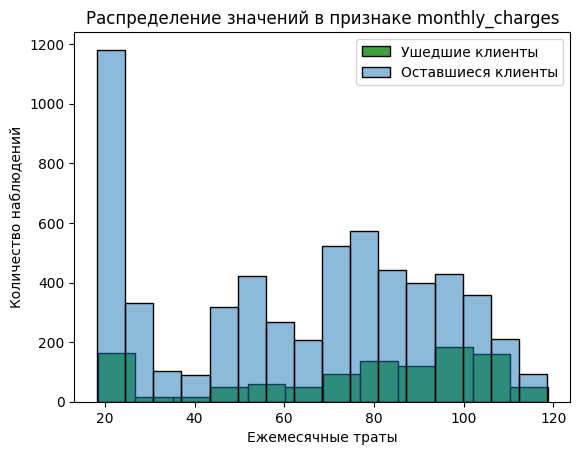

In [25]:
# изучим распределение месячных трат среди ушедших и оставшихся клиентов
ax = sns.histplot(df_1['monthly_charges'], 
                  color='g',
                  label='Ушедшие клиенты')
sns.histplot(df_0['monthly_charges'],
             ax=ax, 
             alpha=0.5,
             label='Оставшиеся клиенты')

ax.legend()
plt.title('Распределение значений в признаке monthly_charges')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Количество наблюдений')
plt.show()

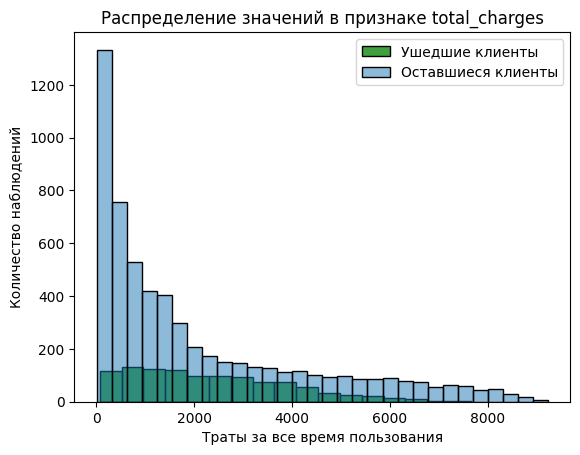

In [26]:
# изучим распределение общих трат за весь срок пользования среди ушедших и оставшихся клиентов
ax = sns.histplot(df_1['total_charges'], 
                  color='g',
                  label='Ушедшие клиенты')
sns.histplot(df_0['total_charges'],
             ax=ax, 
             alpha=0.5,
             label='Оставшиеся клиенты')

ax.legend()
plt.title('Распределение значений в признаке total_charges')
plt.xlabel('Траты за все время пользования')
plt.ylabel('Количество наблюдений')
plt.show()

Как можно заметить по графикам распределения трат отличаются, у клиентов которые продолжают пользоваться услугами заметны высокие всплески на минимальных показателях общих трат за весь периуд пользования. Также можно заметить что пользователи отказавшиеся от услуг компании были подключены по большей части к дорогим тарифам. Изучим некоторые статистики по колонкам monthly_charges и total_charges для 2х групп клиентов.

In [27]:
# изучим некоторые статистики для клиентов продолжающих пользоваться услугами компании
df_0[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,5942.000000,5942.000000
mean,62.763455,2067.943095
std,29.844462,2193.827140
min,18.250000,19.050000
25%,30.062500,374.352500
50%,69.200000,1192.800000
75%,87.237500,3173.837500
max,118.600000,9221.380000


In [28]:
# изучим некоторые статистики для клиентов отказавшихся от услуг компании
df_1[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,1101.000000,1101.000000
mean,75.546004,2371.377275
std,29.116213,1581.862275
min,18.400000,77.840000
25%,56.150000,1048.050000
50%,84.200000,2139.030000
75%,99.500000,3404.910000
max,118.750000,7649.760000


Среднии и медианные показатели по месячным и общим тратам выше в группе клиентов отказавшихся от услуг компании.

In [29]:
# для удобства изменим тип данных в признаке contract_duration с timedelta на int
df['contract_duration'] = df['contract_duration'].dt.days.astype('int16')
df_0['contract_duration'] = df_0['contract_duration'].dt.days.astype('int16')
df_1['contract_duration'] = df_1['contract_duration'].dt.days.astype('int16')

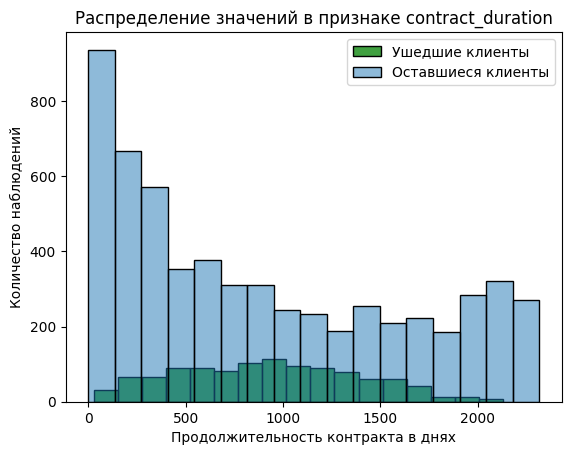

In [30]:
# изучим распределение признака общее время контракта на момент выгрузки данных
ax = sns.histplot(df_1['contract_duration'], 
                  color='g',
                  label='Ушедшие клиенты')
sns.histplot(df_0['contract_duration'],
             ax=ax, 
             alpha=0.5,
             label='Оставшиеся клиенты')

ax.legend()
plt.title('Распределение значений в признаке contract_duration')
plt.xlabel('Продолжительность контракта в днях')
plt.ylabel('Количество наблюдений')
plt.show()

In [31]:
# изучим некоторые статистики признака contract_duration для клиентов отказавшихся от услуг компании
df_1['contract_duration'].describe()

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: contract_duration, dtype: float64

Изучив распределение значений в признаке contract_duration мы видим хороший прирост новых клиентов за последний 1-1.5 года. По отказавшимся от услуг можно сказать что средняя продолжительность контракта составила около 2.5 лет, минимальный срок 28 дней максимальный чуть меньше 6 лет.

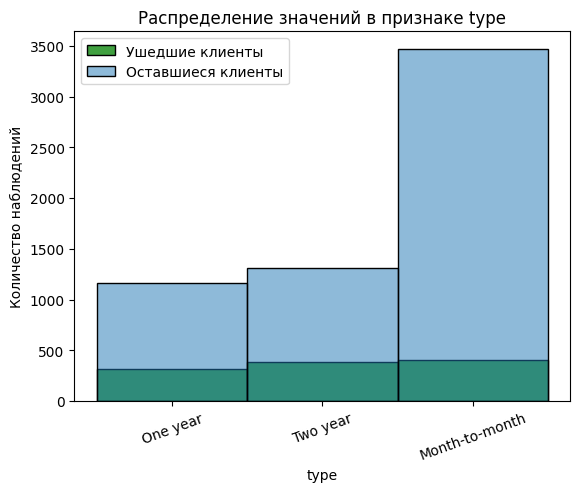

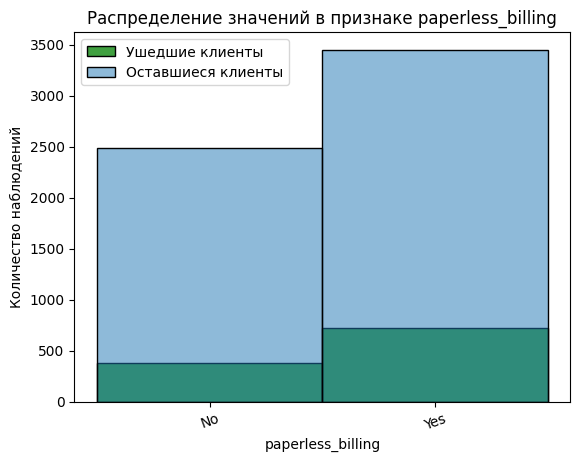

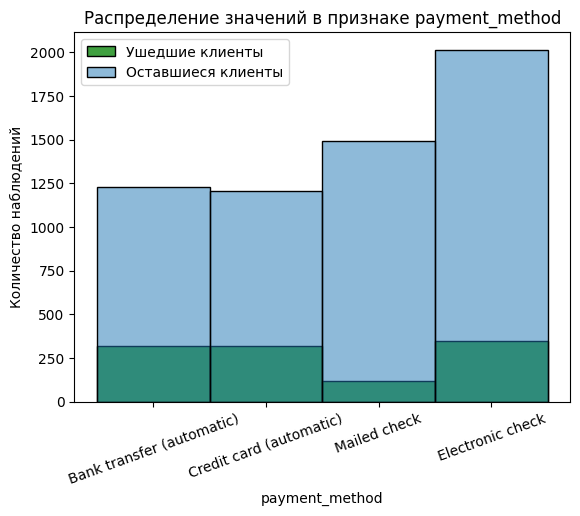

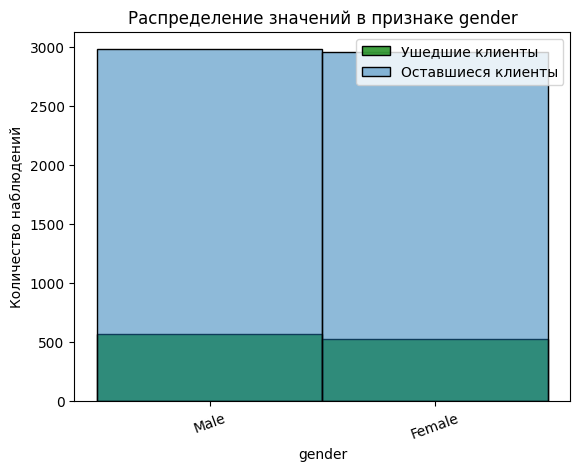

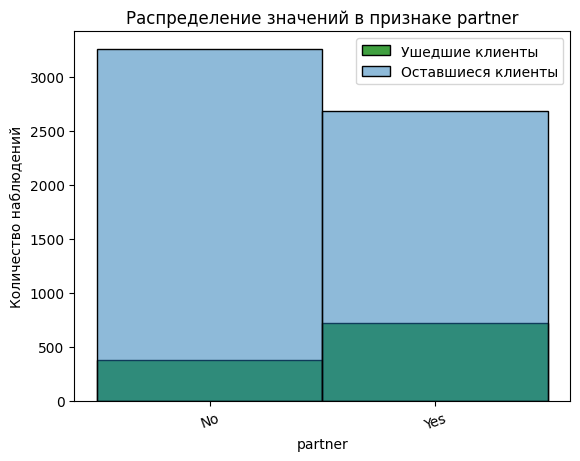

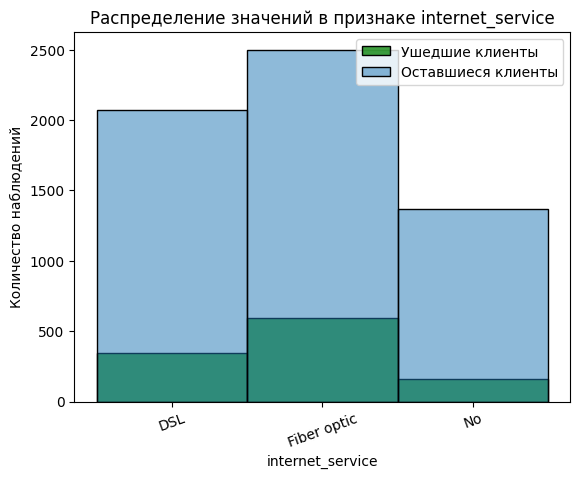

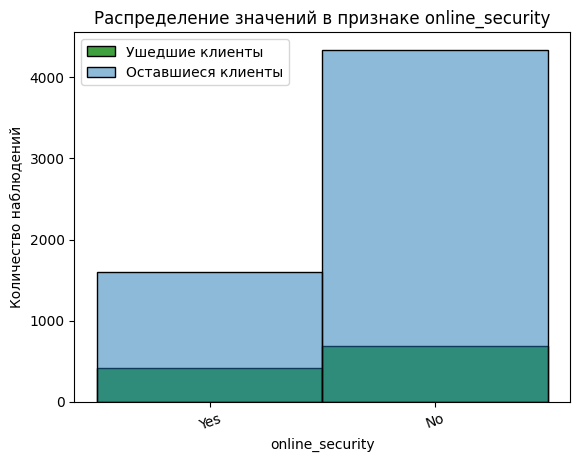

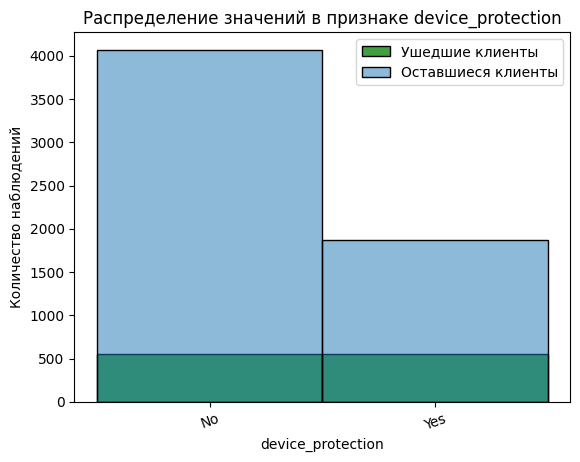

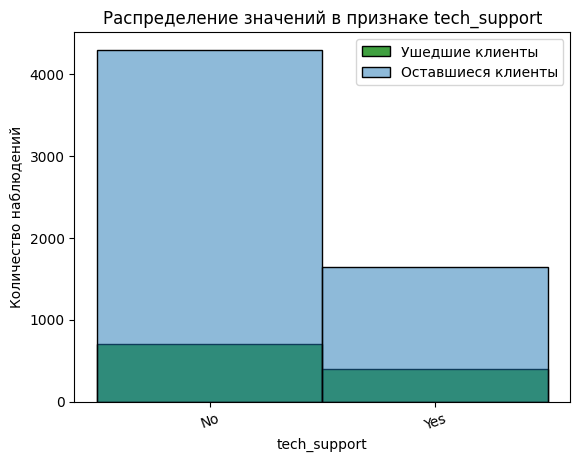

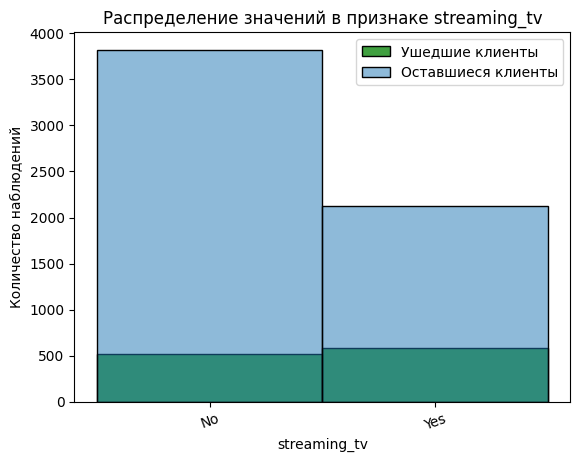

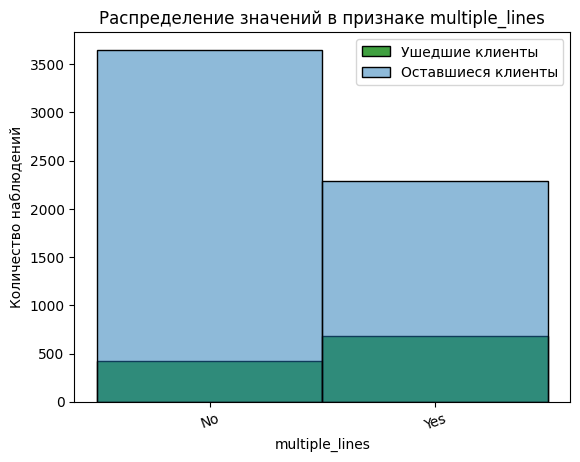

In [32]:
# изучим разницу в распределениях по другим признакам с помощью цикла for и списка интересующих признаков
x = ['type', 
     'paperless_billing', 
     'payment_method', 
     'gender', 'partner', 
     'internet_service', 
     'online_security', 
     'device_protection', 
     'tech_support', 
     'streaming_tv', 
     'multiple_lines']

for col in df_0[x].columns:
    ax = sns.histplot(df_1[col], 
                  color='g',
                  label='Ушедшие клиенты')
    sns.histplot(df_0[col],
             ax=ax, 
             alpha=0.5,
             label='Оставшиеся клиенты')

    ax.legend()
    plt.xticks(rotation=20)
    plt.title(f'Распределение значений в признаке {col}')
    plt.ylabel('Количество наблюдений')
    plt.show()
    print('='*75)

После изучения признаков можно отметить:
- Типы контракта у ушедших клиентов равномерно распределены в отличии от группы оставшихся пользователей у которых самый популярный тип с большим отрывом это month-to-month.
- В признаке paperless_billing нет различий в распределении.
- метод оплаты mailed check самый не популярный в отличии от остальных методов которые распределены равномерно среди ушедших клиентов.
- В признаке gender нет различий в распределении. Мужчин и женщин примерно поровну.
- Интересное распределение в признаке partner, среди ушедших клиетов почти в 2 раза больше женатых а среди оставшихся преобладают "свободные" пользователи.
- Распределение в признаке internet_service минимально. Убольшей части клиентов обеих груп был подключен интернет с приоритетом к оптоволокну.
- В признаке online_security большая часть клиентов из обеих групп не пользуется данной услугой.
- В признаке device_protection среди ушедших пользователей услуга была подключена ровно у половины, а вот среди оставшихся с огромным отрывом лидируют клиенты не подключившие данную услугу.
- В признаке tech_support в обеих группах преобладают клиенты не подключавшие данную услугу.
- Услугой streaming_tv пользовалось больше половины ушедших клиентов, и меньшая часть оставшихся.
- Услугой multiple_lines пользовалось больше половины ушедших клиентов, и меньшая часть оставшихся.

Подготовим признаки нашего датасета к обучению моделей.

In [33]:
# создадим 2 выборки: признаки и таргет
X = df.drop(['customer_id', 'total_charges', 'begin_date', 'end_date', 'target'], axis=1)
y = df['target']

In [34]:
# разделим выборку на тренировочную и тестовую в формате 75% 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS, stratify=y)

In [35]:
# проверим размеры наших выборок
display(f'Размер тренировочной выборки: {X_train.shape[0]} строки, {X_train.shape[1]} столбцов')
display(f'Размер тренировочного целевого признака: {y_train.shape[0]} строки')
display(f'Размер тестовой выборки: {X_test.shape[0]} строка, {X_test.shape[1]} столбцов')
display(f'Размер тестового целевого признака: {y_test.shape[0]} строка')

'Размер тренировочной выборки: 5282 строки, 17 столбцов'

'Размер тренировочного целевого признака: 5282 строки'

'Размер тестовой выборки: 1761 строка, 17 столбцов'

'Размер тестового целевого признака: 1761 строка'

In [36]:
# обнулим индексы в полученных выборках
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [37]:
# закодируем категориальные признаки методом OneHotEncoder, удаляем первый столбец
cat_columns = ['type', 
               'paperless_billing', 
               'payment_method', 
               'gender', 
               'partner', 
               'dependents', 
               'internet_service', 
               'online_security',
               'online_backup',
               'device_protection', 
               'tech_support', 
               'streaming_tv', 
               'streaming_movies', 
               'multiple_lines']

encoder = OneHotEncoder(drop='first', handle_unknown='error') 

X_train_ohe = pd.DataFrame(
    encoder.fit_transform(X_train[cat_columns]).toarray(),
    columns=encoder.get_feature_names_out()
)

X_test_ohe = pd.DataFrame(
    encoder.transform(X_test[cat_columns]).toarray(),
    columns=encoder.get_feature_names_out()
)

In [38]:
# объединим кодированные признаки с основными выборками
X_train = pd.concat(
    [X_train, X_train_ohe], axis=1).drop(X_train[cat_columns], axis=1)

X_test = pd.concat(
    [X_test, X_test_ohe], axis=1).drop(X_test[cat_columns], axis=1)

In [39]:
# создадим функцию для вывода и визуализации интересующих нас метрик
def display_scores(model, features, target, proba=0.5):

    """функция считающая метрики: f1, precission, recall, roc_auc_score. Выводит на экран:
       две круговые диаграммы  отношений TP к FP и TP к FN  как precision и recall,
       график ROC AUC со значением этой метрики. Также два графика, первый для наглядности
       отношения всех таргетов possitive к таргетам negative, под ним с соблюдением пропорций
       значения TP FN FP TN. Такой график позволяет наглядно видеть сколько 'лишних' объектов
       посчитала модель за позитивных и сколько неправильно определила как негативные"""



    # определение основных метрик
    # задание порога вероятности

    pred_proba = model.predict_proba(features)[:, 1]

    proba_mod = np.where(pred_proba>proba, 1, 0)
    conf_matrix = confusion_matrix(target, proba_mod)
    precision = precision_score(target, proba_mod)
    recall = recall_score(target, proba_mod)
    roc_auc = roc_auc_score(target, pred_proba)


    # ввывод на печать наименования модели и f_score
    
    print(type(model).__name__)
    print()
    print(f'roc_auc: {roc_auc}')

    # отрисовка полученных значений на графике

    fpr, tpr, threshold = roc_curve(target, pred_proba)
    roc_auc = roc_auc_score(target, pred_proba)

    fig = plt.figure(figsize=(20, 10))


    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n ({:d} )".format(pct, absolute)

    ax_1 = fig.add_subplot(2, 3, 1)
    ax_2 = fig.add_subplot(2, 3, 2)
    ax_3 = fig.add_subplot(2, 3, 3)
    ax_4 = fig.add_subplot(10, 1, 7)
    ax_5 = fig.add_subplot(10, 1, 8)


    ax_1.pie([ conf_matrix[1][1], conf_matrix[0][1]],
             textprops=dict(color="black", fontsize=16),
             startangle=140,
             shadow=True,
             autopct= lambda pct: func(pct, [conf_matrix[1][1], conf_matrix[0][1]]),
             labels = ['TP', 'FP']
            )

    ax_2.pie([ conf_matrix[1][1],  conf_matrix[1][0]],
             textprops=dict(color="black", fontsize=16),
             startangle=140,
             shadow=True,
             autopct= lambda pct: func(pct, [conf_matrix[1][1], conf_matrix[0][1]]),
             labels = ['TP', 'FN']
            )


    inc = 0
    pn = ['TP', 'FN', 'FP', 'TN']
    pos_neg = ['Positive', 'Negative']
    colors = ['green', 'lime', 'yellow', 'orange']
    tp = np.unique(target, return_counts=True)

    for i, x in enumerate(tp[1][::-1]):
        ax_4.bar(x/2 + inc, 1, x, color=colors[i*3] )
        ax_4.text(x/2 + inc-150, 0.3, pos_neg[i], fontsize=24)
        inc += x

    inc=0
    for i, x in enumerate(conf_matrix.reshape(-1)[::-1]):
        ax_5.bar(x/2 + inc, 1, x, color=colors[i])
        ax_5.text(x/2 + (inc-35), 0.3, pn[i], fontsize=20)
        ax_5.text(x/2 + inc, 0.6, str(x), fontsize=12)
        inc += x

    ax_4.axis('off')
    ax_5.axis('off')
    ax_3.plot(fpr, tpr, 'b')
    ax_3.set_ylabel('True Positive Rate')
    ax_3.set_xlabel('False Positive Rate')
    ax_1.set(title = 'precission = '+ str(round(precision,6)), xticks=[], yticks=[])
    ax_2.set(title = 'recall = ' + str(round(recall,6)), xticks=[], yticks=[])
    ax_3.set(title = 'ROC AUC = ' + str(round(roc_auc,6)), xticks=[], yticks=[])

    plt.show()

In [40]:
%%time
# подберем гиперпараметры для model_tree (DecisionTreeClassifier) с помощью GridSearchCV
# инициализируем модель
dtc_grid = DecisionTreeClassifier(random_state=RS, class_weight='balanced')

# задаем параметры для подбора лучшего результата
params = {'criterion': ['entropy', 'gini'],
          'max_depth': np.arange(1, 20)
          }

# зададим настройки подбора параметров методу GridSearchCV
grid_dtc = GridSearchCV(dtc_grid, 
                        param_grid=params,
                        scoring='roc_auc',
                        cv=6,
                        n_jobs=4)

# обучаем модель и выводим оптимальные параметры и roc_auc_score
grid_dtc.fit(X_train, y_train)

model_dtc = grid_dtc.best_estimator_
dtc_best_score = grid_dtc.best_score_

display(grid_dtc.best_params_)
display(dtc_best_score)

{'criterion': 'gini', 'max_depth': 6}

0.7859133193173108

CPU times: total: 219 ms
Wall time: 1.4 s


In [41]:
%%time
# подберем гиперпараметры для model_forest (RandomForestClassifier) с помощью GridSearchCV
# инициализируем модель
rfc_grid = RandomForestClassifier(random_state=RS, class_weight='balanced')

# задаем параметры для подбора лучшего результата
params = {'criterion': ['entropy', 'gini'],
          'max_depth': np.arange(5, 15, 1),
          'n_estimators': np.arange(50, 151, 50)
          }

# зададим настройки подбора параметров методу GridSearchCV
grid_rfc = GridSearchCV(rfc_grid, 
                        param_grid=params,
                        scoring='roc_auc',
                        cv=6,
                        n_jobs=4)

# обучаем модель и выводим оптимальные параметры и roc_auc_score
grid_rfc.fit(X_train, y_train)

model_rfc = grid_rfc.best_estimator_
rfc_best_score = grid_rfc.best_score_

display(grid_rfc.best_params_)
display(rfc_best_score)

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 150}

0.8296218159812206

CPU times: total: 828 ms
Wall time: 33.5 s


In [42]:
%%time
# подберем лучшие параметры для модели LGBMClassifier
# инициализируем модель
LGBMC = LGBMClassifier(random_state=RS, class_weight='balanced')

# задаем параметры для подбора лучшего результата
params_LGBMC = {
    'num_leaves': np.arange(50, 101, 50),
    'learning_rate': [0.1, 0.3, 0.5, 0.6, 0.7],
    'max_depth': [5, 10, 15],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

# зададим настройки подбора параметров методу GridSearchCV
grid_LGBMC = GridSearchCV(LGBMC, 
                          param_grid=params_LGBMC, 
                          scoring='roc_auc', 
                          verbose=1, 
                          n_jobs=4)

# обучаем модель и выводим оптимальные параметры и roc_auc_score
grid_LGBMC.fit(X_train, y_train)

model_LGBMC = grid_LGBMC.best_estimator_
LGBMC_best_score = grid_LGBMC.best_score_

display(grid_LGBMC.best_params_)
display(LGBMC_best_score)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


{'learning_rate': 0.6,
 'max_depth': 5,
 'num_leaves': 50,
 'reg_alpha': 0.5,
 'reg_lambda': 0.0}

0.8922499879538635

CPU times: total: 1.11 s
Wall time: 31.8 s


In [43]:
%%time
# подберем лучшие параметры для модели LGBMClassifier
# инициализируем модель
CAT = CatBoostClassifier(random_state=RS, class_weights=(1, 5))

# задаем параметры для подбора лучшего результата
params_CAT = {
    'n_estimators': np.arange(50, 351, 50),
    'learning_rate': [0.1, 0.3, 0.5, 0.6, 0.7]
}

# зададим настройки подбора параметров методу GridSearchCV
grid_CAT = GridSearchCV(CAT, 
                        param_grid=params_CAT, 
                        scoring='roc_auc',
                        verbose=False, 
                        n_jobs=4,
                        cv=6)

# обучаем модель и выводим оптимальные параметры и roc_auc_score
grid_CAT.fit(X_train, y_train)

model_CAT = grid_CAT.best_estimator_
CAT_best_score = grid_CAT.best_score_

display(grid_CAT.best_params_)
display(CAT_best_score)

0:	learn: 0.6112858	total: 136ms	remaining: 47.4s
1:	learn: 0.5578999	total: 138ms	remaining: 24.1s
2:	learn: 0.5317983	total: 141ms	remaining: 16.3s
3:	learn: 0.5149651	total: 143ms	remaining: 12.4s
4:	learn: 0.5004129	total: 145ms	remaining: 10s
5:	learn: 0.4831263	total: 148ms	remaining: 8.47s
6:	learn: 0.4754517	total: 150ms	remaining: 7.35s
7:	learn: 0.4675373	total: 152ms	remaining: 6.51s
8:	learn: 0.4607016	total: 154ms	remaining: 5.85s
9:	learn: 0.4600509	total: 156ms	remaining: 5.3s
10:	learn: 0.4528411	total: 158ms	remaining: 4.88s
11:	learn: 0.4472624	total: 161ms	remaining: 4.53s
12:	learn: 0.4425808	total: 163ms	remaining: 4.23s
13:	learn: 0.4358934	total: 166ms	remaining: 3.98s
14:	learn: 0.4343804	total: 168ms	remaining: 3.75s
15:	learn: 0.4293659	total: 170ms	remaining: 3.54s
16:	learn: 0.4241211	total: 172ms	remaining: 3.37s
17:	learn: 0.4216772	total: 174ms	remaining: 3.21s
18:	learn: 0.4185220	total: 176ms	remaining: 3.07s
19:	learn: 0.4147040	total: 178ms	remaining:

{'learning_rate': 0.3, 'n_estimators': 350}

0.9149404974452512

CPU times: total: 3.55 s
Wall time: 37.8 s


In [44]:
# выведем на экран таблицу с итогами исследования
models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier', 'CatBoostClassifier']
table = pd.DataFrame(np.array([dtc_best_score, rfc_best_score, LGBMC_best_score, CAT_best_score]), index=models)
table.set_axis(['roc_auc'], axis=1, inplace=True)
table

,roc_auc
DecisionTreeClassifier,0.785913
RandomForestClassifier,0.829622
LGBMClassifier,0.892250
CatBoostClassifier,0.914940


На кроссвалидации модель CatBoostClassifier показала лучший результат по roc_auc = 0.917389. Провери данную модель с подобранными гиперпараметрами на тестовой выборке.

CatBoostClassifier

roc_auc: 0.9022782332069007


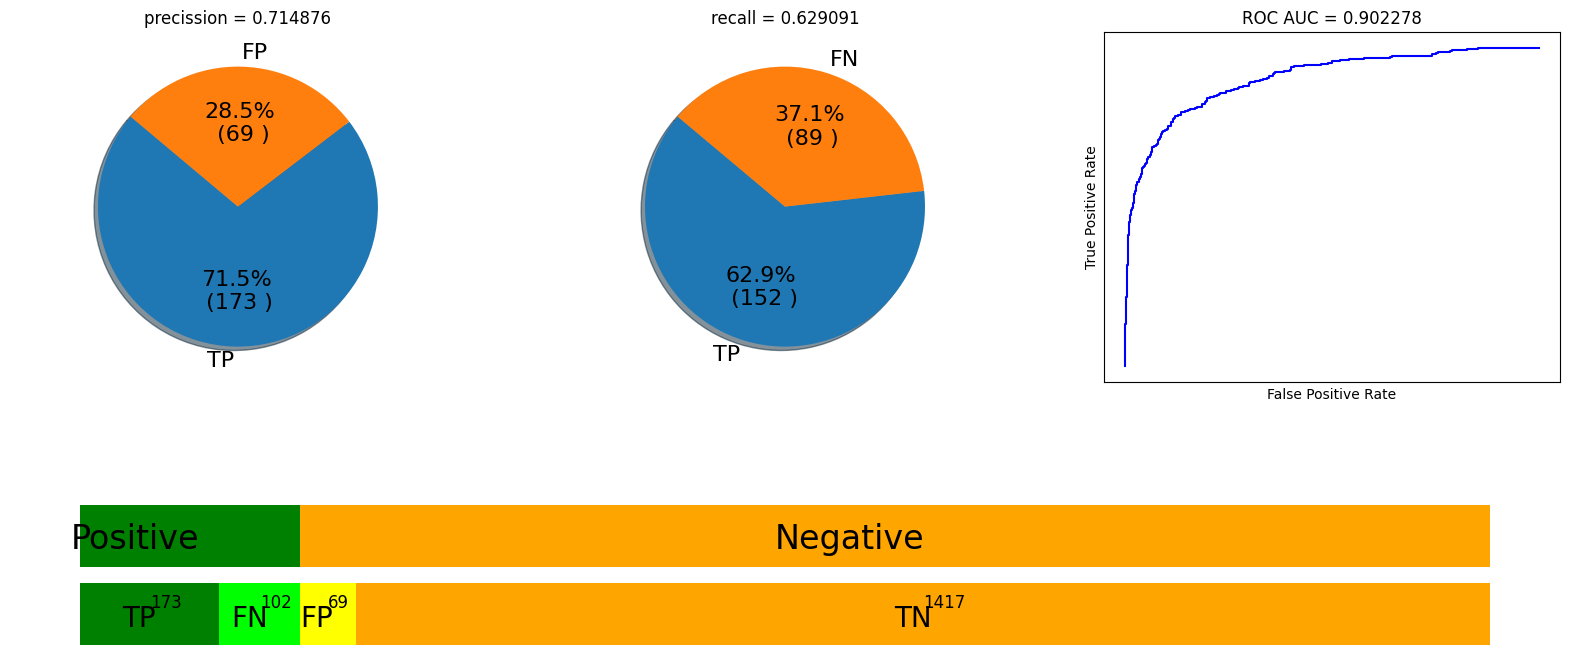

In [45]:
# проверим модель на тестовой выборке
display_scores(model_CAT, X_test, y_test)

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Отличный результат на тестировании, поздравляю!
    
</div>

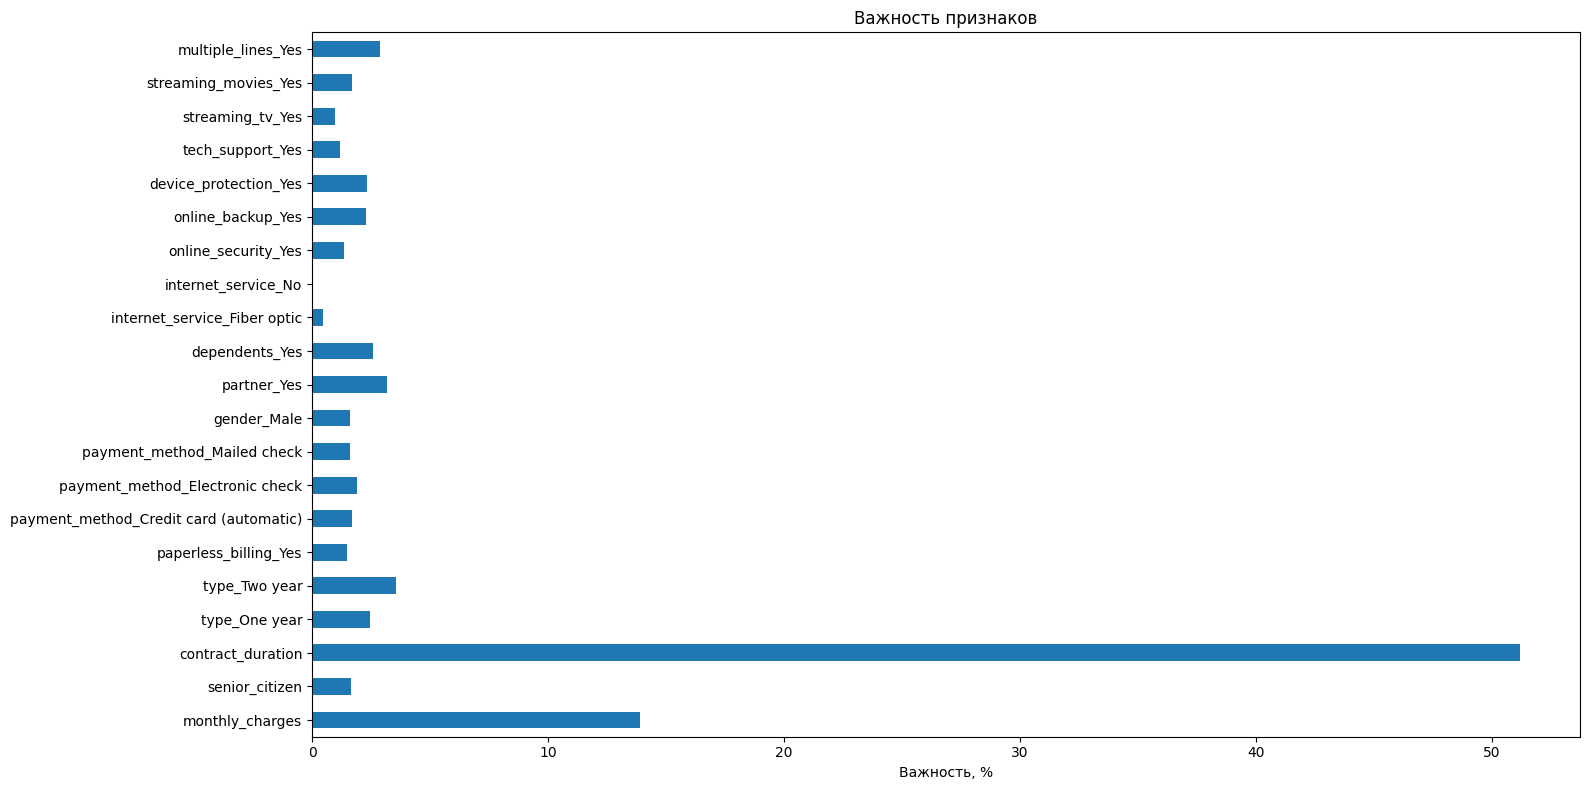

In [46]:
# изучим важность признаков для нашей модели
cat_imp = pd.Series(model_CAT.get_feature_importance(), X_train.columns)
fig, ax = plt.subplots(figsize=(16, 8))
cat_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Важность, %')
fig.tight_layout()

Модель CatBoostClassifier показала на тестовой выборке roc_auc = 0.9022782332069007. Поставленная задача выполнена. По графику важности признаков отчетливо видно что добавленный нами признак contract_duration имеет наибольший приоритет с огромным отрывом от остальных, следующий по важности признак monthly_charges. Все остальные признаки показали более низкий результат. Стоит отметить что такой признак как тип интернет подключения практически не влияет на результат модели.

## ***Вывод***


По ходу исследования были выполнены следующие шаги:
- Датасеты собраны в один файл по признаку customer_id.
- Заполнены пропуски:
    - в признаке total_charges пропуски заполнены значениями месячного платежа так как эти пользователи были зарегистрированны в день выгрузки данных.
    - В остальных колонках (internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, ultiple_lines) пропуски заполнены значением 'No' так как данные пропуски появились по причине того что данные услуги не были подключены.
- Исследованы распределения значений в признаках (описано ниже).
- Добавлен новый признак - contract_duration - общая продолжительнось контракта на момент выгрузки данных.
- Исследовали корреляцию числовых признаков. Признаки total_charges и monthly_charges показали сильную положительную корреляцию. Было принято решение удалить один из признаков перед обучением моделей.
- Исследованна разница в распределении значений в 2х группах по целевому признаку (описано ниже).
- Подготовили данные к обучению моделей:
    - Удалили не нужные нам признаки ('customer_id', 'total_charges', 'begin_date', 'end_date')
    - Разделили данные на признаки и таргет.
    - Разделили данные на обучающую и тестовую выборку в отношении 75%/25% (test_size=0.25, random_state=80523, stratify=y)
    - Закодировали категориальные признаки с помощью OneHotEncoder.
    - Для 4х моделей (DecisionTreeClassifier, RandomForestClassifier, LGBMClassifier, CatBoostClassifier) были подобраны лучшие гиперпараметры с использованием GridSearchCV.
        - Все модели были обученны на списке признаков (type, paperless_billing, payment_method, monthly_charges, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines, contract_duration)
    - На кроссвалидации модель CatBoostClassifier показала лучший результат по roc_auc = 0.917389. Лучшие параметры для данной модели:
        - learning_rate = 0.3, 
        - n_estimators = 350,
        - class_weights = (1, 5),
        - cv = 6
    - Исследовали важность признаков лучшей модели (описано ниже).
    - Модель CatBoostClassifier показала на тестовой выборке roc_auc = 0.9022782332069007
    
    
В ходе исследования при попытке сменить тип данных в признаке total_charges были обнаружены строковые значения - ' ', эти пользователи были зарегестрированны в день выгрузки данных и информацию о первом платеже еще не внесли. Заменили данные значения на значения из колонки monthly_charges, так как эти пользователи успели оплатить только первый месяц. Также изменили тип данных на float.
Все оставшиеся пропуски у нас находятся в признаках наличия подключенной услуги. Будем считать что пропуски означают отсутствие данной услуги. Заполнили все строкой 'No'.


После детального рассмотрения данных можно отметить:
- Первые клиенты компании зарегистрировались в октябре 2013г, последнии в день выгрузки данных - февраль 2020.
- Первый клиент отказавшийся от услуг - июнь 2014. Количество отказов росло с ростом появления новых клиентов.
- Большинство клиентов выбирает ежемесячную оплату за услуги и безналичный расчет.
- Метод оплаты равномерно распределен среди 4х способов с небольшим перевесом у 'Электронный чек'
- Ежемесячная оплата от 18.25 до 118.75, среднее в районе 65, медиана 70.35.
- Обшие траты на услуги за все время от 19.05 до 9221.38 среднее 2116.8, медиана 1344.5. Распределение смещено.
- Пользователей по половому признаку примерно поровну.
- Пенсионный статус примерно у 16% пользователей.
- Пользователей в браке и вне примерно поровну.
- Интернет сервис: оптоволокно немного предпочтительнее DSL. Услугой не пользуется около 21% клиентов компании.
- Всеми доп. услугами к интернет соединению пользуются примерно поровну.
- Длительность контракта от 0 дней до 2314 дней, среднее 898 дней, медиана 761 день. Средний показатель продолжительности контракта на момент выгрузки данных около 2.5 лет.


После сравнения признаков ушедших и оставшихся клиентов можно отметить:
- Типы контракта у ушедших клиентов равномерно распределены в отличии от группы оставшихся пользователей у которых самый популярный тип с большим отрывом это month-to-month.
- В признаке paperless_billing нет различий в распределении.
- метод оплаты mailed check самый не популярный в отличии от остальных методов которые распределены равномерно среди ушедших клиентов.
- В признаке gender нет различий в распределении. Мужчин и женщин примерно поровну.
- Интересное распределение в признаке partner, среди ушедших клиетов почти в 2 раза больше женатых а среди оставшихся преобладают "свободные" пользователи.
- Распределение в признаке internet_service минимально. Убольшей части клиентов обеих груп был подключен интернет с приоритетом к оптоволокну.
- В признаке online_security большая часть клиентов из обеих групп не пользуется данной услугой.
- В признаке device_protection среди ушедших пользователей услуга была подключена ровно у половины, а вот среди оставшихся с огромным отрывом лидируют клиенты не подключившие данную услугу.
- В признаке tech_support в обеих группах преобладают клиенты не подключавшие данную услугу.
- Услугой streaming_tv пользовалось больше половины ушедших клиентов, и меньшая часть оставшихся.
- Услугой multiple_lines пользовалось больше половины ушедших клиентов, и меньшая часть оставшихся.

Была изучена важности признаков для лучшей модели.

По графику важности признаков отчетливо видно что добавленный нами признак contract_duration имеет наибольший приоритет с огромным отрывом от остальных, следующий по важности признак monthly_charges. Все остальные признаки показали более низкий результат. Стоит отметить что такой признак как тип интернет подключения практически не влияет на результат модели.


- Все пункты плана проекта были выполнены.
- С трудностями не столкнулся.
- Ключевые шаги: 
    - Предобработка данных и подготовка их к обучению моделей. 
    - Подбор гиперпараметров под выбранную метрику качества модели

Поставленная задача выполнена.